# Hand written digits Classification using Convolutional Neural Network (CNN)

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

The link for this dataset is availabe here: http://yann.lecun.com/exdb/mnist/

- It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.
- The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.



In [2]:
!pip install -r req_mnist.txt

# Import Libraries

In [1]:
import numpy as np     # use for plotting and data visualisation
%matplotlib inline
                       # Library to implement deep learning models 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

np.random.seed(0)

# Import Data

MNIST is availabe in keras datasets, therefore we can direclty download it for keras repository


In [2]:
from keras.datasets import mnist

(x_train, y_train) , (x_test, y_test) = mnist.load_data()

Visualise the dataset before model training:

- MNIST has 6000 images in training set and 10000 images in test set.
- Size of each image in 28 x 28 i.e height is 28 pixels and width is 28 pixels.



In [3]:
# Shape of training and test set

print(f'Shape of training set is: {x_train.shape} | Shape of testset: {x_test.shape}')

Shape of training set is: (60000, 28, 28) | Shape of testset: (10000, 28, 28)


# Visualisation Example:



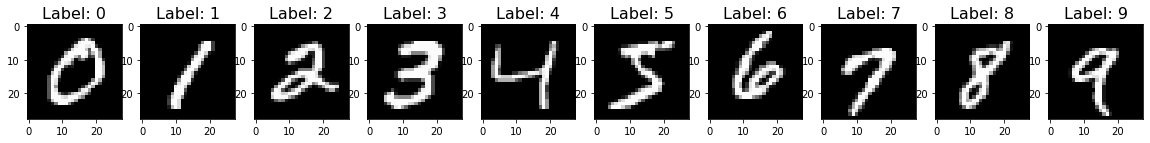

In [4]:
num_classes = 10           # mnist dataset has 10 classes i.e. digits for 0 to 9

f, ax = plt.subplots(1, num_classes, figsize=(20,20))  # create a place holder images of each class 


for i in range(0, num_classes):                # loop for number of classes in out case 1 to 10
    samples = x_train[y_train== i][0]          # finds the sampes for training set to match for loop index
    ax[i].imshow(samples, cmap='gray')
    ax[i].set_title("Label: {}".format(i), fontsize=16)

In [5]:
# Let's first understand the dataset

print('The data type of training set is: ',type(x_train))

print('----------------------------------------------------------')

# data type is numpy array

print('The shape of training data is:', x_train.shape)

print('----------------------------------------------------------')

# shape of the dataset is 60,000 with each sample or class have size of 28 x 28

print('The shape of each class:', x_train[0].shape)


The data type of training set is:  <class 'numpy.ndarray'>
----------------------------------------------------------
The shape of training data is: (60000, 28, 28)
----------------------------------------------------------
The shape of each class: (28, 28)


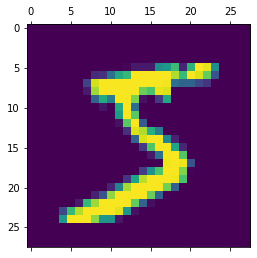

In [6]:
# visualise each sample:

plt.matshow(x_train[0])     # change the value in square bracket to see other classes


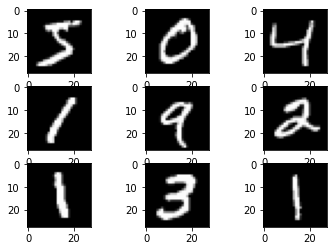

In [7]:
for i in range(9):                   # This piece of code plots the gray scale images of first 9 samples in dataset
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Data Preprocessing

When using a convolutional layer as the first layer to our model, we need to reshape our data to (n_images, x_shape, y_shape, channels). All you really need to know is that you should set channels to 1 for grayscale images and set channels to 3 when you have a set of RGB-images as input.

In [8]:
trainX = x_train.reshape(-1, 28,28, 1) # Negative one is the same as specifying the total number of images in the training set.
testX = x_test.reshape(-1, 28,28, 1)  

print('The shape of training data is:', trainX.shape)   # add

The shape of training data is: (60000, 28, 28, 1)


In [9]:
# Modifying the values of each pixel such that they range from 0 to 1 will improve the rate at which our model learns. 

trainX = trainX.astype('float32')   
testX = testX.astype('float32')
trainX = trainX / 255                   # pixel values varies for 0 to 255
testX = testX / 255




# One hot label encoding

Our model cannot work with categorical data directly. Ergo we must use one hot encoding. In one hot encoding, the digits 0 through 9 are represented as a set of nine zeros and a single one. The digit is determined by the location of the number 1. For example, you’d represent a 3 as [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [17]:
trainY = to_categorical(y_train, num_classes)
testY = to_categorical(y_test, num_classes)
#testY = y_test

# Define a CNN Model

Next, we need to define a baseline convolutional neural network model for the problem.

- The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

- For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

- Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

- All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

- The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

In [11]:
# Function for defining the convolutional neural network: The architicture is 2D convolutional layer, Maxpooling layer, to dense layers. 

def modelcnn(conv_size, hidden_units):
    model= Sequential()
    model.add(Conv2D(conv_size, (3, 3), activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hidden_units, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])   # cross entropy loss as loss function.
    model.summary()
    return model    





In [12]:
batch_size = 1000                   # loop through the entire data in size of 100 images per batch
epochs=10                          # Number of epoches for traning
hidden_units = 5                   # number of neuron for dense layer [by change the size of neuron the performance will change]
conv_size=5

model = modelcnn(conv_size=conv_size, hidden_units=hidden_units)  # Initilising the model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 5)         50        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 5)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 845)               0         
                                                                 
 dense (Dense)               (None, 5)                 4230      
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
Total params: 4,340
Trainable params: 4,340
Non-trainable params: 0
______________________________________________________

In [19]:
# Model training using training samples

history = model.fit(trainX, trainY, batch_size=batch_size, epochs=epochs)  

# In model training accuracy is kept as the metric. For each epoch, the accuracy of the model will keep increasing.

Epoch 1/10
60/60 [==============================] - 4s 71ms/step - loss: 1.7437 - accuracy: 0.3476
Epoch 2/10
60/60 [==============================] - 4s 74ms/step - loss: 1.6880 - accuracy: 0.3733
Epoch 3/10
60/60 [==============================] - 4s 70ms/step - loss: 1.6184 - accuracy: 0.4122
Epoch 4/10
60/60 [==============================] - 4s 74ms/step - loss: 1.5444 - accuracy: 0.4352
Epoch 5/10
60/60 [==============================] - 4s 71ms/step - loss: 1.4802 - accuracy: 0.4517
Epoch 6/10
60/60 [==============================] - 4s 73ms/step - loss: 1.4252 - accuracy: 0.4739
Epoch 7/10
60/60 [==============================] - 5s 76ms/step - loss: 1.3746 - accuracy: 0.5000
Epoch 8/10
60/60 [==============================] - 4s 71ms/step - loss: 1.3131 - accuracy: 0.5316
Epoch 9/10
60/60 [==============================] - 4s 69ms/step - loss: 1.2332 - accuracy: 0.5894
Epoch 10/10
60/60 [==============================] - 4s 70ms/step - loss: 1.1557 - accuracy: 0.6283


In [20]:
# Model evaluating using test sample:

# Here we will test the model using test data samples from mnist

# This will tell us how accuratly the model is trained.

# To further improve the model performance, we need to train the hyper parameters.


_, acc = model.evaluate(testX, testY, verbose=0)   
print('The test accuray of the CNN model is:', acc)

# The performance of model is not good which can be improved by change the hyper-parameter


The test accuray of the CNN model is: 0.6471999883651733


In [21]:
# model predicitions

y_pred = model.predict(testX)
y_pred[0]

array([1.0096545e-04, 1.8938337e-01, 1.6486552e-04, 1.1257834e-03,
       5.2813724e-02, 7.2450330e-03, 2.8733443e-04, 6.7262501e-01,
       8.9032734e-03, 6.7350626e-02], dtype=float32)

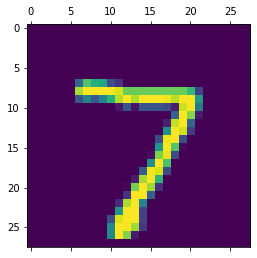

In [22]:
plt.matshow(testX[0])

In [23]:
np.argmax(y_pred[0])

7

In [24]:
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels[:5]

[7, 3, 1, 0, 4]

In [26]:
len(y_test)

10000

In [27]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 841,    0,    0,    2,   11,   10,  113,    0,    3,    0],
       [   0, 1041,    0,    6,    0,    1,    0,    5,   80,    2],
       [  72,    7,  440,  111,   23,    6,   94,    5,  252,   22],
       [   3,   18,    2,  693,    0,   90,   66,   12,  116,   10],
       [  14,    3,    6,    0,  552,    8,   10,   41,   29,  319],
       [   6,    4,   13,  174,   47,  357,  121,   28,  120,   22],
       [ 221,    1,  108,   33,   12,   26,  526,    1,   27,    3],
       [   4,  136,    4,    2,   57,    3,    0,  698,   29,   95],
       [   2,    6,   14,   70,    6,   78,   70,   24,  629,   75],
       [   8,   13,    1,    2,  137,   11,    6,   91,   45,  695]])>

Text(69.0, 0.5, 'Actual')

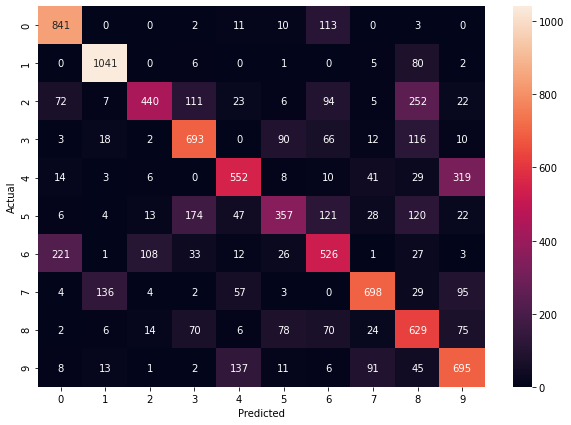

In [33]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
#sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

- The diagnal of the above confusion matrix represnets the number of correct samples predicted. 
- There were 1000 samples per class.
- In case of 0 it is mostly miss classified with 6. 
- The performance of model can be improved by change the hyperparameters.

In [42]:
import session_info
session_info.show()